In [1]:
batchNum = 1 # Can take values amongst (1,2,3,4)

def getInterval(): return 25
def getFeatureCount(): return 20
def getSensorColNames(): return ['T24','T30','T50','P30','Nf','Nc','Ps30','phi','NRf','BPR','htBleed',
                                 'W31','W32']
def getColumnNames(): return ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30',
                              'T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB',
                              'htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

from sklearn.preprocessing import StandardScaler
def featureScaling(training, test):
    sc = StandardScaler()
    training["data"][getSensorColNames()] = sc.fit_transform(training["data"][getSensorColNames()])
    test["data"][getSensorColNames()] = sc.transform(test["data"][getSensorColNames()])
    return training, test

import pandas as pd
import numpy as np
import sys

basePath = "C:/Users/Raider/Downloads/IIT ISM Dhanbad/project/lstm from scratch 2"
if basePath not in sys.path: sys.path.append(basePath)

def getDataFromFile(file_name, machineCount):
    #Read data from file
    data = pd.read_csv(file_name,sep=" ",header=None)

    #Drop empty value columns
    data.drop(columns=[26,27],inplace=True)

    #Assign columns user friendly names
    data.columns = getColumnNames()

    #Remove constant values columns
    data.drop(columns=['setting_1','setting_2','Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

    #Remove columns that have very little impact on RUL
    data.drop(columns=['P15','NRc'],inplace=True)
    
    #Fix machine id for different batches
    if machineCount != 0: data["unit_number"] = data["unit_number"] + machineCount
    
    #Caculate and add RUL to data
    return data

def mergeBatches(data):
    for fileName in data["files"]:
        try:
            data["data"] = pd.concat([data["data"], getDataFromFile(fileName, data["sampleCount"])], axis=0)
        except:
            data["data"] = getDataFromFile(fileName, 0)
        data["sampleCount"] = data["data"]["unit_number"].unique().size
    return data

def readRUL(rul):
    for fileName in rul["files"]:
        try:
            rul["data"] = pd.concat(rul["data"], pd.read_csv(fileName,sep=" ",header=None), axis=0)
        except:
            rul["data"] = pd.read_csv(fileName,sep=" ",header=None)

    #Drop empty value columns
    rul['data'].drop(columns=[1],inplace=True)
    return rul

def mergeTestAndRUL(test, rul):
    rul['data'].columns = ['more']
    rul['data']['unit_number'] = rul['data'].index + 1
    test['data'] = test['data'].merge(rul['data'], on=['unit_number'], how='left')
    #test['data']["RUL"] = test['data']["RUL"]+test['data']["more"]
    test['data'].drop('more', axis=1, inplace=True)
    return test

import warnings 
warnings.filterwarnings('ignore')

#Load and transform data
training, test, rul = {}, {}, {}
basePath = "/Users/ashutoshkedar/Downloads/data/"
training["files"] = [basePath + "train_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
test["files"] = [basePath + "test_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
rul["files"] = [basePath + "RUL_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]

#Merge multiple batches
training = mergeBatches(training)
test = mergeBatches(test)
rul = readRUL(rul)

#Perform feature scaling
training, test = featureScaling(training, test)

#Add RUL and test data
test = mergeTestAndRUL(test, rul)

In [2]:
def addEventIndicator(training, test):
    event_indicator = [0]
    for unit in list(set(training['data']['unit_number'])):
        event_indicator.append(max(training['data'][training['data']['unit_number'] == unit]['time_in_cycles']) + event_indicator[-1])
    event_indicator = event_indicator[1:]
    target = [int(i+1 in event_indicator) for i in range(len(training['data']))]
    training['data']['target'] = target

    event_indicator = [0]
    for unit in list(set(test['data']['unit_number'])):
        event_indicator.append(max(test['data'][test['data']['unit_number'] == unit]['time_in_cycles']) + event_indicator[-1])
    event_indicator = event_indicator[1:]
    target = [int(i+1 in event_indicator) for i in range(len(test['data']))]
    test['data']['target'] = target
    return training, test
training, test = addEventIndicator(training, test)

In [3]:
def get_list_of_machine_data(data):
    sorted_data = data.sort_values(by=['unit_number', 'time_in_cycles'])
    grouped_data = sorted_data.groupby('unit_number')
    max_timestamps = 800 #grouped_data['time_in_cycles'].apply(len).max()

    result = []
    for unit_number, machine_data in grouped_data:
        timestamps = machine_data['time_in_cycles'].values
        parameters = machine_data.iloc[:, 2:-1].values
        target_events = machine_data['target'].values

        timestamps = np.pad(timestamps, (0, max_timestamps - len(timestamps)), constant_values=-3)
        padding_length = max_timestamps - parameters.shape[0]
        parameters = np.pad(parameters, ((0, padding_length), (0, 0)), constant_values=-3)
        target_events = np.pad(target_events, (0, padding_length), constant_values=-3)

        machine_dict = {
            'unit_number': unit_number,
            'timestamps': timestamps,
            'parameters': parameters,
            'target_events': target_events
        }

        result.append(machine_dict)
    return result

In [4]:
import tensorflow as tf

# Define the RNN-SURV model
class RNN_SURV_Model(tf.keras.Model):
    def __init__(self, hidden_units):
        super(RNN_SURV_Model, self).__init__()
        self.hidden_units = hidden_units
        self.rnn_layer = tf.keras.layers.LSTM(self.hidden_units, return_sequences=True, activation='sigmoid',
            kernel_initializer=tf.keras.initializers.GlorotUniform()  # Xavier initialization
        )
        self.dense_layer = tf.keras.layers.Dense(2, activation='sigmoid',
            kernel_initializer=tf.keras.initializers.GlorotUniform()  # Xavier initialization
        )

    def call(self, inputs):
        x = self.rnn_layer(inputs)
        x = self.dense_layer(x)
        return x

class RNN_SURV_loss(tf.keras.losses.Loss):
    def __init__(self, alpha):
        super(RNN_SURV_loss, self).__init__()
        self.alpha = alpha

    def call(self, y_true, y_pred):
        event_indicator = tf.cast(y_true[:, :, 0], dtype=tf.float32)
        survival_time = tf.cast(y_true[:, :, 1], dtype=tf.float32)
        hazard_ratio = tf.exp(y_pred[:, :, 0])
        log_survival_time = y_pred[:, :, 1]
        log_likelihood = tf.multiply(event_indicator, log_survival_time - tf.math.log(tf.reduce_sum(hazard_ratio, axis=1, keepdims=True)))
        log_rank = tf.reduce_sum(hazard_ratio, axis=1, keepdims=True)
        return tf.reduce_mean(log_likelihood + self.alpha * log_rank)

# Preprocess the data
def preprocess_data(data):
    # Extract input features (parameters) and target variable
    parameters = data['parameters']
    target_events = data['target_events']

    # Create a mask to ignore padding values during training
    mask = np.expand_dims(parameters != -3, axis=0)

    # Prepare the data for the RNN model
    inputs = np.expand_dims(parameters, axis=0)
    labels = np.expand_dims(np.stack([target_events, [0 for i in range(len(target_events))]], axis=1), axis=0)  # Use target_events as survival time for simplicity
    return inputs, labels, mask

def trainModel(trainingData, alpha = 0.25):
    # Create the RNN-SURV model
    hidden_units = 64
    model = RNN_SURV_Model(hidden_units)

    # Compile the model with RMSprop optimizer
    loss_function = RNN_SURV_loss(alpha)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=loss_function)

    # Training loop
    num_epochs = 30

    # Accumulate data for training
    batch_inputs, batch_labels, batch_masks = [], [], []

    # Iterate over training data for each machine
    for machine_data in trainingData:
        # Preprocess the machine data
        inputs, labels, mask = preprocess_data(machine_data)

        # Accumulate data
        batch_inputs.append(inputs)
        batch_labels.append(labels)
        batch_masks.append(mask)

    # Convert accumulated data to arrays
    batch_inputs = np.concatenate(batch_inputs, axis=0)
    batch_labels = np.concatenate(batch_labels, axis=0)
    batch_masks = np.concatenate(batch_masks, axis=0)

    # Train the model on the accumulated data
    model.train_on_batch(batch_inputs, batch_labels, sample_weight=batch_masks)
    
    return model


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_metrics(model, data):
    # Accumulate data for testing
    inputs, labels, mask = [], [], []

    # Iterate over test data for each machine
    for machine_data in data:
        # Preprocess the machine data
        input1, label1, mask1 = preprocess_data(machine_data)

        # Accumulate data
        inputs.append(input1)
        labels.append(label1)
        mask.append(mask1)

    # Convert accumulated data to arrays
    inputs = np.concatenate(inputs, axis=0)
    labels = np.concatenate(labels, axis=0)
    mask = np.concatenate(mask, axis=0)

    # Evaluate the model on the test data
    loss = model.evaluate(inputs, labels, sample_weight=mask, verbose=0)

    # Make predictions on the test data
    predictions = model.predict(inputs)[:, :, 0]  # Predicted log survival time

    # Calculate metrics for test data
    score = []
    score.append(mean_absolute_error(labels[:, :, 1].flatten(), predictions.flatten()))
    score.append(mean_squared_error(labels[:, :, 1].flatten(), predictions.flatten()))
    return score

trainingData = get_list_of_machine_data(training['data'])
testData = get_list_of_machine_data(test['data'])

trueModel = trainModel(trainingData, 0.25)

trainingScores = get_metrics(trueModel, trainingData)
testScores = get_metrics(trueModel, testData)

# Print the evaluation metrics
print("Train MAE: {:.4f}".format(trainingScores[0]))
print("Train MSE: {:.4f}".format(trainingScores[1]))
print("Test MAE: {:.4f}".format(testScores[0]))
print("Test MSE: {:.4f}".format(testScores[1]))


2023-05-18 16:09:36.116968: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 0s 28ms/step
Train MAE: 0.3823
Train MSE: 0.1474
Test MAE: 0.3739
Test MSE: 0.1404


In [6]:
# Preprocess the machine data
inputs, _, _ = preprocess_data(trainingData[0])

# Get the output from the RNN model
output = trueModel.predict(inputs)

# Print the output
print(output[0])

1/1 [==============================] - 0s 18ms/step
[[0.45795575 0.30962023]
 [0.4602175  0.29733565]
 [0.4321119  0.30543008]
 ...
 [0.36294657 0.29004282]
 [0.36294657 0.29004282]
 [0.36294657 0.29004282]]


In [7]:
def linearize_list(nested_list):
    result = []
    for item in nested_list:
        if not isinstance(item, np.float32):
            result += linearize_list(item)
        else:
            result.append(item)
    return result

In [8]:
import matplotlib.pyplot as plt
import math
import bisect

def get_biases(data):
    # Define the range of alpha values to investigate
    alpha_values = [0.00001, 0.2, 0.4, 0.6, 0.8, 0.99999]

    # Define a list to store the sum of squares of differences for each alpha
    mean_sum_diff = []
    mean_sum_diff_RNN = []
    mean_sum_diff_dense = []

    # Iterate over each alpha value
    for alpha in alpha_values:
        trueModel = trainModel(trainingData, alpha)
        true_weights = trueModel.get_weights()
        trueWeights = linearize_list(true_weights)

        # Perform jackknife sampling
        subsamples = []
        num_data = len(data)
        for i in range(num_data):
            subsample = np.concatenate([data[:i], data[(i+1):]])
            subsamples.append(subsample)

        # Train the model on each subsample and calculate the weights
        sum_diff, sum_diff_RNN, sum_diff_dense = 0.0, 0.0, 0.0
        count, count_RNN, count_Dense = 0, 0, 0

        for subsample in subsamples:
            # Train the model using the current subsample and alpha
            model = trainModel(subsample, alpha)

            # Calculate the weights obtained using the subsample
            subsample_weights = model.get_weights()
            subsampleWeights = linearize_list(subsample_weights)

            # Calculate the sum of squares of differences between weights
            sum_diff = np.sum([abs(true_w - subsample_w) for true_w, subsample_w in zip(trueWeights, subsampleWeights)])
            sum_diff_RNN = np.sum([abs(true_w - subsample_w) for true_w, subsample_w in zip(trueWeights[:-130], subsampleWeights[:-130])])
            sum_diff_dense = np.sum([abs(true_w - subsample_w) for true_w, subsample_w in zip(trueWeights[-130:], subsampleWeights[-130:])])

            if not math.isnan(sum_diff):
                sum_diff += sum_diff
                count += 1
            if not math.isnan(sum_diff_RNN):
                sum_diff_RNN += sum_diff_RNN
                count_RNN += 1
            if not math.isnan(sum_diff_dense):
                sum_diff_dense += sum_diff_dense
                count_Dense += 1

        # Store the sum of squares of differences for the current alpha
        res = sum_diff/count
        print(alpha, res)
        mean_sum_diff.append(res)
        mean_sum_diff_RNN.append(sum_diff_RNN/count_RNN)
        mean_sum_diff_dense.append(sum_diff_dense/count_Dense)

    return mean_sum_diff, mean_sum_diff_RNN, mean_sum_diff_dense

In [9]:
def getOutlierIndices(trainingData):
    lifespans = [sum([int(timestamp != -3) for timestamp in machine['timestamps']]) for machine in trainingData]
    q1 = np.percentile(lifespans, 25)
    q3 = np.percentile(lifespans, 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    outlier_indices = [index for index, num in enumerate(lifespans) if num < lower_bound or num > upper_bound][::-1]
    return outlier_indices
outlier_indices_batch1 = getOutlierIndices(trainingData)
length_batch1 = len(trainingData)
outlier_indices_batch1, length_batch1

([95, 91, 68], 100)

In [10]:
#Add outliers from batch 2
batchNum = 2 # Can take values amongst (1,2,3,4)
training, test, rul = {}, {}, {}
basePath = "/Users/ashutoshkedar/Downloads/data/"
training["files"] = [basePath + "train_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
test["files"] = [basePath + "test_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
rul["files"] = [basePath + "RUL_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]

#Merge multiple batches
training = mergeBatches(training)
test = mergeBatches(test)
rul = readRUL(rul)

#Perform feature scaling
training, test = featureScaling(training, test)

#Add RUL and test data
test = mergeTestAndRUL(test, rul)

training, test = addEventIndicator(training, test)

trainingDataFromBatch2 = get_list_of_machine_data(training['data'])

outlier_indices_batch2 = getOutlierIndices(trainingDataFromBatch2)
for outlier_index in outlier_indices_batch2:
    trainingDataFromBatch2[outlier_index]['unit_number'] = len(trainingData) + 1
    trainingData.append(trainingDataFromBatch2[outlier_index])

In [11]:
#Add outliers from batch 3
batchNum = 3 # Can take values amongst (1,2,3,4)
training, test, rul = {}, {}, {}
basePath = "/Users/ashutoshkedar/Downloads/data/"
training["files"] = [basePath + "train_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
test["files"] = [basePath + "test_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
rul["files"] = [basePath + "RUL_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]

#Merge multiple batches
training = mergeBatches(training)
test = mergeBatches(test)
rul = readRUL(rul)

#Perform feature scaling
training, test = featureScaling(training, test)

#Add RUL and test data
test = mergeTestAndRUL(test, rul)

training, test = addEventIndicator(training, test)

trainingDataFromBatch3 = get_list_of_machine_data(training['data'])

outlier_indices_batch3 = getOutlierIndices(trainingDataFromBatch3)
for outlier_index in outlier_indices_batch3:
    trainingDataFromBatch3[outlier_index]['unit_number'] = len(trainingData) + 1
    trainingData.append(trainingDataFromBatch3[outlier_index])

In [12]:
#Add outliers from batch 4
batchNum = 4 # Can take values amongst (1,2,3,4)
training, test, rul = {}, {}, {}
basePath = "/Users/ashutoshkedar/Downloads/data/"
training["files"] = [basePath + "train_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
test["files"] = [basePath + "test_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]
rul["files"] = [basePath + "RUL_FD00" + str(i) + ".txt" for i in range(batchNum,batchNum+1)]

#Merge multiple batches
training = mergeBatches(training)
test = mergeBatches(test)
rul = readRUL(rul)

#Perform feature scaling
training, test = featureScaling(training, test)

#Add RUL and test data
test = mergeTestAndRUL(test, rul)

training, test = addEventIndicator(training, test)

trainingDataFromBatch4 = get_list_of_machine_data(training['data'])

outlier_indices_batch4 = getOutlierIndices(trainingDataFromBatch4)
for outlier_index in outlier_indices_batch4:
    trainingDataFromBatch4[outlier_index]['unit_number'] = len(trainingData) + 1
    trainingData.append(trainingDataFromBatch4[outlier_index])

In [13]:
print('Number of outliers:', len(outlier_indices_batch1) + len(trainingData)-length_batch1)
print('Numnber of machines in data', len(trainingData))

Number of outliers: 13
Numnber of machines in data 110


In [14]:
pureData = trainingData.copy()
for outlierIndex in range(len(trainingData)-1, length_batch1-1, -1):
    del pureData[outlierIndex]
for outlierIndex in outlier_indices_batch1:
    del pureData[outlierIndex]

In [15]:
#Corrupted data
corruptedDataBiases = get_biases(trainingData)
corruptedDataBiases

1e-05 27.494273792613637
0.2 27.531103515625
0.4 27.457679332386363
0.6 27.27432528409091
0.8 27.350395063920455
0.99999 27.91285733309659


([27.494273792613637,
  27.531103515625,
  27.457679332386363,
  27.27432528409091,
  27.350395063920455,
  27.91285733309659],
 [26.989026988636365,
  27.046202503551136,
  26.993346058238636,
  26.78882723721591,
  26.89897238991477,
  27.437422318892047],
 [0.5052485032515093,
  0.4848995555530895,
  0.46433271928267045,
  0.4854991566051136,
  0.4514244773171165,
  0.47543404319069604])

In [16]:
#Pure data
pureDataBiases = get_biases(pureData)
pureDataBiases

1e-05 31.0314815560567
0.2 31.215837930895617
0.4 31.051969233247423
0.6 31.197819346005154
0.8 31.230151618878867
0.99999 31.18238311452964


([31.0314815560567,
  31.215837930895617,
  31.051969233247423,
  31.197819346005154,
  31.230151618878867,
  31.18238311452964],
 [30.5461299935567,
  30.693673989207475,
  30.51772662290593,
  30.694260430090207,
  30.72802734375,
  30.628126006765463],
 [0.4853540400868839,
  0.5221636270739368,
  0.5342441834125322,
  0.5035566349619442,
  0.5021245110895216,
  0.5542562425751048])

In [17]:
e = [[abs(pureDataBiases[i][j]-corruptedDataBiases[i][j]) for j in range(len(pureDataBiases[0]))] for i in range(len(pureDataBiases))]
e

[[3.537207763443064,
  3.6847344152706185,
  3.5942899008610603,
  3.923494061914244,
  3.879756554958412,
  3.2695257814330496],
 [3.557103004920336,
  3.6474714856563395,
  3.524380564667293,
  3.9054331928742982,
  3.8290549538352288,
  3.190703687873416],
 [0.019894463164625398,
  0.03726407152084732,
  0.06991146412986177,
  0.018057478356830636,
  0.05070003377240512,
  0.07882219938440871]]

In [20]:
def getVar(test_list):
    mean = sum(test_list) / len(test_list)
    return sum((i - mean) ** 2 for i in test_list) / len(test_list)

getVar(pureDataBiases[0]), getVar(corruptedDataBiases[0])

(0.006289237772215801, 0.0410803643825458)

In [21]:
pb = [pureDataBiases[0][j] for j in [e[0].index(i) for i in sorted(e[0])]]
pb

[31.18238311452964,
 31.0314815560567,
 31.051969233247423,
 31.215837930895617,
 31.230151618878867,
 31.197819346005154]

In [22]:
cb = [corruptedDataBiases[0][j] for j in [e[0].index(i) for i in sorted(e[0])]]
cb

[27.91285733309659,
 27.494273792613637,
 27.457679332386363,
 27.531103515625,
 27.350395063920455,
 27.27432528409091]

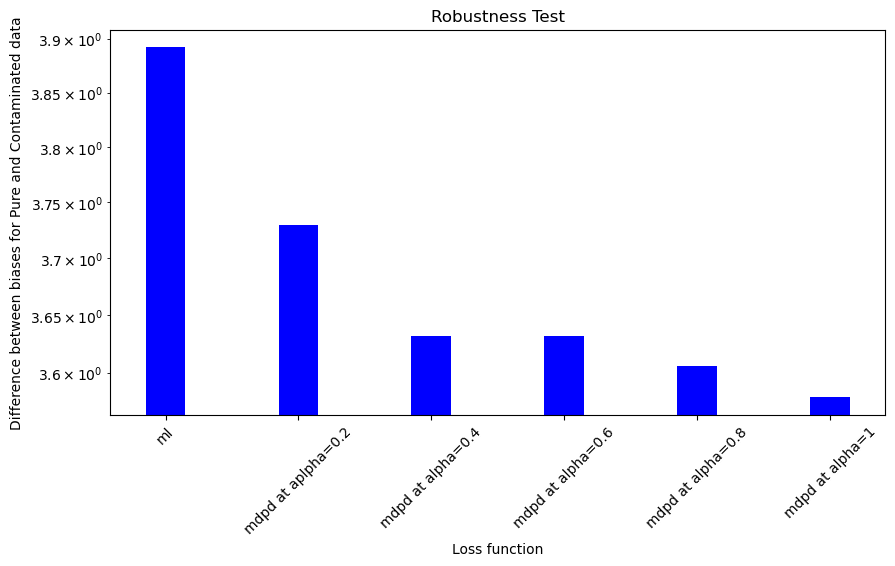

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Create the bar graph
#e = [3.6059884240276467, 3.6318591846298034, 3.8921958286961136, 3.5789332038571935, 3.6315232452993236, 3.7301361970624427]
fig, ax = plt.subplots(figsize=(10, 5))
labels = ['ml', 'mdpd at aplpha=0.2', 'mdpd at alpha=0.4', 'mdpd at alpha=0.6', 'mdpd at alpha=0.8', 'mdpd at alpha=1']
values = sorted(e, reverse=True)
ax.bar(labels, values, color='blue', width=0.3)

ax.set_xlabel("Loss function")
ax.set_ylabel("Difference between biases for Pure and Contaminated data")
ax.set_title("Robustness Test")
ax.set_yscale('log')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()


In [24]:
"""
p = [31.373849770457475,
31.202752496778352,
31.168139900128867,
31.23904135792526,
31.322305895618555,
31.249551989368555]
c = [27.481653941761362,
27.47261629971591,
27.536616654829544,
27.607182173295456,
27.71631747159091,
27.670618785511362
]
"""
p,c=pb,cb

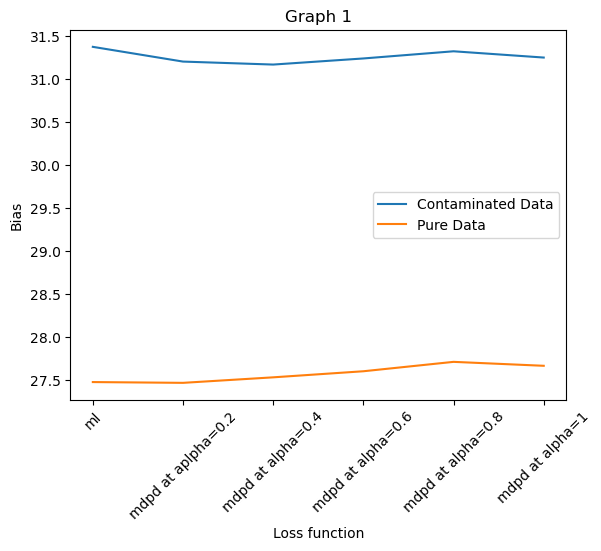

In [25]:
import matplotlib.pyplot as plt

# Sample data
x = ['ml', 'mdpd at aplpha=0.2', 'mdpd at alpha=0.4', 'mdpd at alpha=0.6', 'mdpd at alpha=0.8', 'mdpd at alpha=1']
y1 = p
y2 = c

# Plotting the first graph
plt.plot(x, y1, label='Contaminated Data')
plt.plot(x, y2, label='Pure Data')
plt.xlabel('Loss function')
plt.ylabel('Bias')
plt.xticks(rotation=45)
plt.title('Graph 1')
plt.legend()
plt.show()

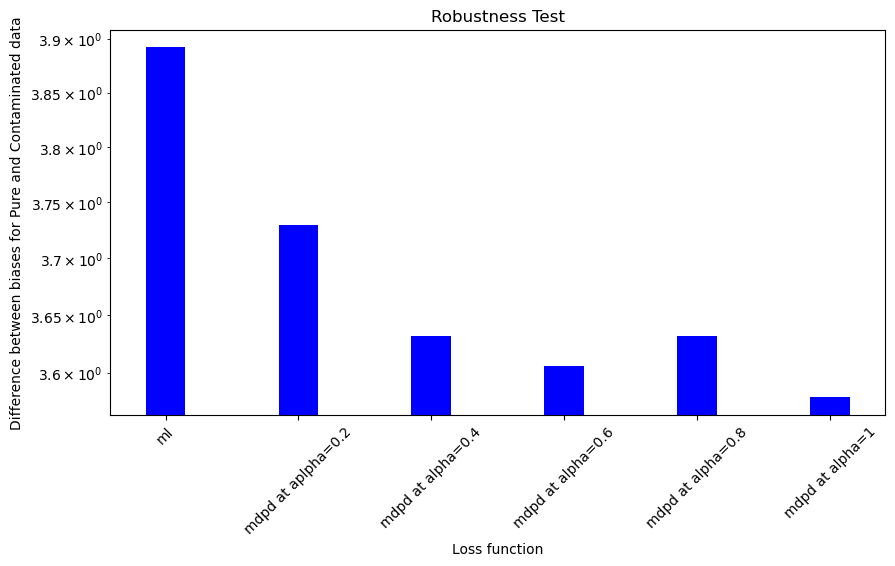

[3.8921958286961136,
 3.7301361970624427,
 3.6315232452993236,
 3.6059884240276467,
 3.6318591846298034,
 3.5789332038571935]

In [26]:
e = [3.8921958286961136,
3.7301361970624427,
3.6315232452993236,
3.6059884240276467,
3.6318591846298034,
3.5789332038571935]

import matplotlib.pyplot as plt
import numpy as np

# Create the bar graph
#e = [3.6059884240276467, 3.6318591846298034, 3.8921958286961136, 3.5789332038571935, 3.6315232452993236, 3.7301361970624427]
fig, ax = plt.subplots(figsize=(10, 5))
labels = ['ml', 'mdpd at aplpha=0.2', 'mdpd at alpha=0.4', 'mdpd at alpha=0.6', 'mdpd at alpha=0.8', 'mdpd at alpha=1']
values = e
ax.bar(labels, values, color='blue', width=0.3)

ax.set_xlabel("Loss function")
ax.set_ylabel("Difference between biases for Pure and Contaminated data")
ax.set_title("Robustness Test")
ax.set_yscale('log')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()

In [61]:
inputs, _, _ = preprocess_data(testData[50])
predictions = trueModel.predict(inputs)

1/1 [==============================] - 0s 30ms/step


In [62]:
for i in predictions[0]:
    print(i/sum(predictions))
print(sum(i for i in predictions[0]))

[0.00206597 0.0014007 ]
[0.00198709 0.00136598]
[0.00196297 0.00122907]
[0.00189974 0.00121605]
[0.00190968 0.00122697]
[0.00188962 0.00124717]
[0.00185901 0.00117096]
[0.00186862 0.00116193]
[0.00189615 0.00118917]
[0.0018088 0.0012033]
[0.00184134 0.00116089]
[0.00175264 0.0012037 ]
[0.00182367 0.00115188]
[0.00185874 0.00109353]
[0.00189353 0.00119322]
[0.00187921 0.00112714]
[0.00188654 0.00112173]
[0.00184263 0.001151  ]
[0.00178516 0.00117801]
[0.00182157 0.00113262]
[0.00176424 0.00112417]
[0.00184444 0.00118541]
[0.00186928 0.00114191]
[0.001779  0.0011096]
[0.00178017 0.00118769]
[0.00187789 0.00113854]
[0.00182027 0.00115015]
[0.00184132 0.00114908]
[0.001804   0.00123953]
[0.00190886 0.00118782]
[0.0018536  0.00116631]
[0.00183793 0.00116376]
[0.00187979 0.00116116]
[0.0018174 0.0012344]
[0.00183682 0.00114221]
[0.00188361 0.00110375]
[0.00173071 0.00112752]
[0.00180516 0.00113323]
[0.00180755 0.0011439 ]
[0.00181488 0.00115253]
[0.0018338  0.00114962]
[0.00179398 0.00115748

In [71]:
testData[80]

{'unit_number': 81,
 'timestamps': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171,

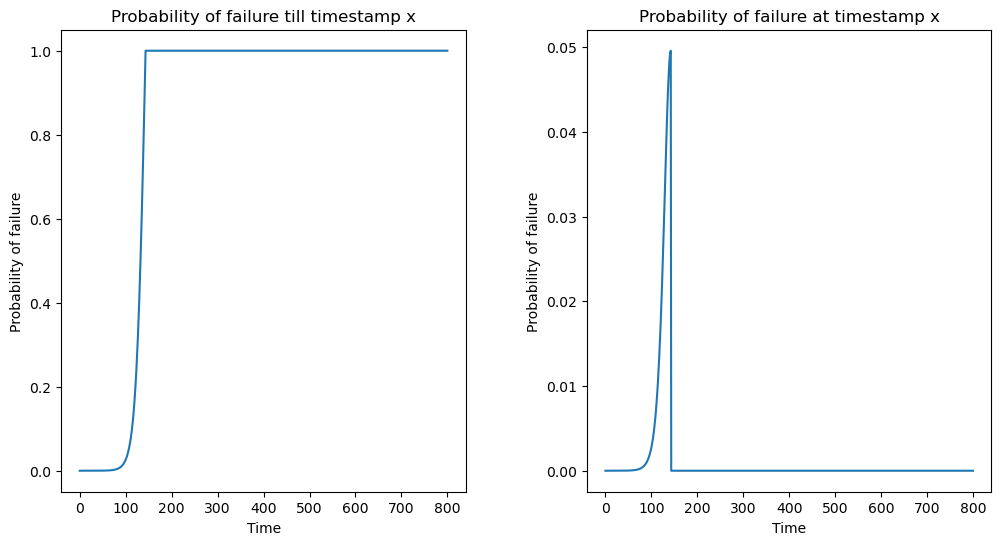

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k*(x-x0)))

array_length = 800
x_values = np.linspace(0, 800, array_length)  # Adjust the range if desired

# Customize the sigmoid parameters for desired behavior
x0 = 143  # Adjust the x-value where y is close to 1
k = 0.1  # Adjust the steepness of the sigmoid curve

sigmoid_values = sigmoid(x_values, x0, k)

# Scale the sigmoid values to reach y = 1 at x = 143
sigmoid_values *= (1 / sigmoid_values[143])

# Set the sigmoid values to a constant value after x = 143
sigmoid_values[143:] = sigmoid_values[143]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original sigmoid values
ax1.plot(x_values, sigmoid_values)
ax1.set_xlabel('Time')
ax1.set_ylabel('Probability of failure')
ax1.set_title('Probability of failure till timestamp x')

# Plot the modified sigmoid values
ax2.plot(x_values, [sigmoid_values[i+1]-sigmoid_values[i] for i in range(len(sigmoid_values)-1)] + [0])
ax2.set_xlabel('Time')
ax2.set_ylabel('Probability of failure')
ax2.set_title('Probability of failure at timestamp x')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the figure with both subplots
plt.show()


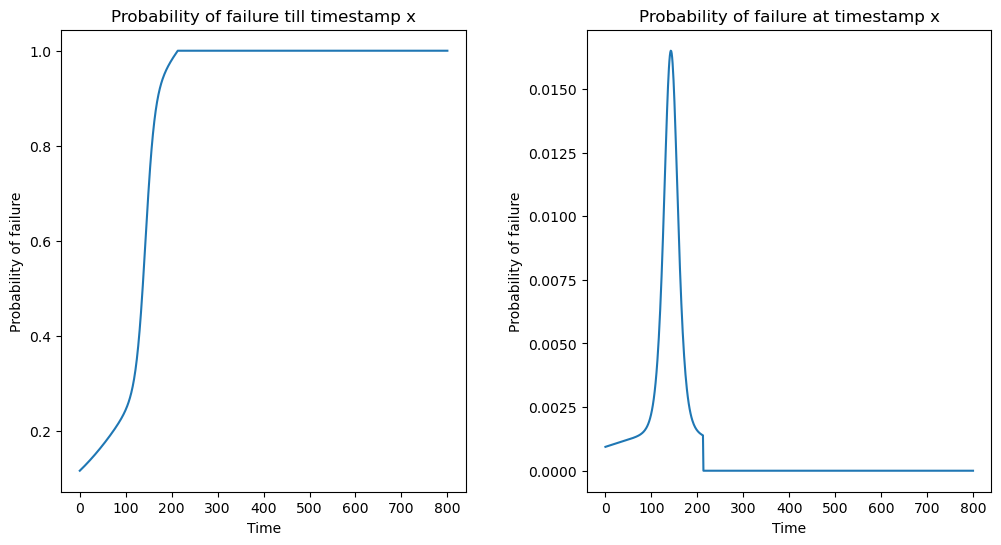

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x, x0, k1, k2):
    return 1 / (1 + np.exp(-k1*(x-x0))) + (1 / (1 + np.exp(-k2*(x-x0))))

array_length = 800
x_values = np.linspace(0, 800, array_length)  # Adjust the range if desired

# Customize the sigmoid parameters for desired behavior
x0 = 143  # Adjust the x-value where y is close to 1
k1 = 0.1  # Adjust the steepness of the first sigmoid curve
k2 = 0.01  # Adjust the steepness of the second sigmoid curve

sigmoid_values = sigmoid(x_values, x0, k1, k2)

# Scale the sigmoid values to reach y = 1 at x = 143
sigmoid_values *= (1 / sigmoid_values[213])

# Adjust the sigmoid values from x = 143 to x = 800 to minimize change
sigmoid_values[213:] = sigmoid_values[213]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original sigmoid values
ax1.plot(x_values, sigmoid_values)
ax1.set_xlabel('Time')
ax1.set_ylabel('Probability of failure')
ax1.set_title('Probability of failure till timestamp x')

# Plot the modified sigmoid values
ax2.plot(x_values, [sigmoid_values[i+1]-sigmoid_values[i] for i in range(len(sigmoid_values)-1)] + [0])
ax2.set_xlabel('Time')
ax2.set_ylabel('Probability of failure')
ax2.set_title('Probability of failure at timestamp x')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the figure with both subplots
plt.show()


In [75]:
x_values[0], x_values[1], x_values[2]

(0.0, 1.0012515644555695, 2.002503128911139)

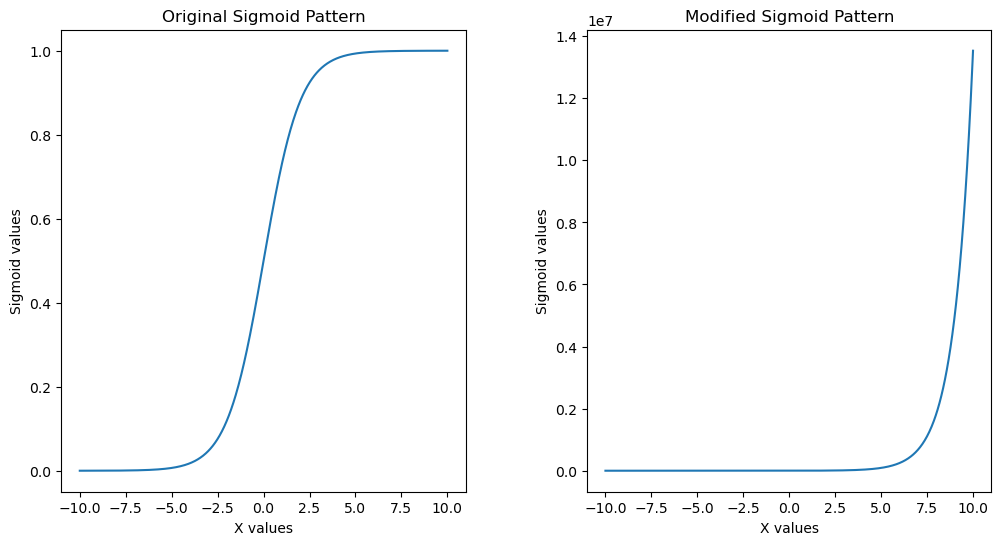

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

array_length = 800
x_values = np.linspace(-10, 10, array_length)  # Adjust the range if desired

# Original Sigmoid Pattern
sigmoid_values_original = sigmoid(x_values)

# Modified Sigmoid Pattern
x0 = 400
k = 0.01
sigmoid_values_modified = sigmoid(x_values - x0) * (1 / sigmoid(x_values - x0)[143])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original sigmoid values
ax1.plot(x_values, sigmoid_values_original)
ax1.set_xlabel('X values')
ax1.set_ylabel('Sigmoid values')
ax1.set_title('Original Sigmoid Pattern')

# Plot the modified sigmoid values
ax2.plot(x_values, sigmoid_values_modified)
ax2.set_xlabel('X values')
ax2.set_ylabel('Sigmoid values')
ax2.set_title('Modified Sigmoid Pattern')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Display the figure with both subplots
plt.show()
